# Exploratory analysis of the bands

In [34]:
%load_ext autoreload
%autoreload 2

from __future__ import annotations

import itertools
import os
import time
import pickle

import numpy as np
import pandas as pd
from glob import glob
from pprint import pprint
from typing import Any, Optional
from collections import defaultdict
from collections.abc import Iterable

import scipy.spatial
import sklearn.cluster
import tensorflow as tf
from tqdm.auto import tqdm
import batcher
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
BANDS_ORDER = ['BLUE', 'GREEN', 'RED', 'SWIR1', 'SWIR2', 'TEMP1', 'NIR', 'DMSP', 'VIIRS'] #split Nightlights
TFRECORD_PATH_TEMPLATE = 'data/ke_dhs_tfrecords_raw/kenya_{year}.tfrecord.gz'

In [1]:
def plot_image_by_band(img, band_order, nrows, title, rgb=None, colorbar=False):
    '''
    Args
    - img: np.array, shape [H, W, C], type float, normalized
    - band_order: list of str, names of the bands in order
    - nrows: int, desired number of rows in the created figure
    - title: str, or None
    - rgb: one of [None, 'merge', 'add']
        - None: do not create a separate RGB image
        - 'merge': plot the RGB bands as a merged image
        - 'add': plot all bands, but also add a merged RGB image
    - colorbar: bool, whether to show colorbar
    '''
    nbands = img.shape[2]
    rgb_to_naxs = {None: nbands, 'merge': nbands - 2, 'add': nbands + 1}
    
    nplots = rgb_to_naxs[rgb]
    ncols = int(np.ceil(nplots / float(nrows)))
    fig_w = min(15, 3*ncols)
    fig_h = min(15, 3*nrows)
    fig, axs = plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=[fig_w, fig_h], constrained_layout=True)
    
    if title is not None:
        fig.suptitle(title, y=1.03)

    # scale image to [0,1]: 0 = -3 std, 0.5 = mean, 1 = +3 std
    scaled_img = np.clip(img / 6.0 + 0.5, a_min=0, a_max=1)
    bands = {band_name: scaled_img[:, :, b] for b, band_name in enumerate(band_order)}

    plots = []
    plot_titles = []
    if rgb is not None:
        r, g, b = bands['RED'], bands['GREEN'], bands['BLUE']
        rgb_img = np.stack([r,g,b], axis=2)
        plots.append(rgb_img)
        plot_titles.append('RGB')

    if rgb == 'merge':
        for band_name in band_order:
            if band_name not in ['RED', 'GREEN', 'BLUE']:
                plots.append(bands[band_name])
                plot_titles.append(band_name)
    else:
        plots += [bands[band_name] for band_name in band_order]
        plot_titles += band_order

    for b in range(len(plots)):
        if len(axs.shape) == 1:
            ax = axs[b]
        else:
            ax = axs[b // ncols, b % ncols]
        # set origin='lower' to match lat/lon direction
        im = ax.imshow(plots[b], origin='lower', cmap='viridis', vmin=0, vmax=1)
        ax.set_aspect('equal')
        ax.axis('off')
        ax.set_title(plot_titles[b])

    if colorbar:
        fig.colorbar(im, orientation='vertical', ax=axs)
        
    plt.show()

In [5]:
def plot_single_img(feature_map):
    lat = np.float32(feature_map['lat'].float_list.value[0])
    lon = np.float32(feature_map['lon'].float_list.value[0])
    country = feature_map['country'].bytes_list.value[0].decode()
    year = int(feature_map['year'].float_list.value[0])
    fig_title = f'Loc: ({lat:.6f}, {lon:.6f}), {country}, {year}'
    print(fig_title)

    img_normalized = []
    for b_name in BAND_ORDER:
        band = np.asarray(feature_map[b_name].float_list.value, dtype=np.float32).reshape(255, 255)
        mean = band.mean()
        std = band.std()
        band = (band - mean) / std
        img_normalized.append(band)
        
    img_normalized = np.stack(img_normalized, axis=2)

    plot_image_by_band(img=img_normalized, band_order=BAND_ORDER, nrows=3, title=fig_title, rgb='add', colorbar=True)

In [7]:
def get_feature_map(tfrecord_path):
    '''Gets feature_map dict of 1st TFRecord in a TFRecord file
    Args
    - tfrecord_path: str, path to a TFRecord file with GZIP compression
    Returns
    - feature_types: dict, maps feature names (str) to tuple of (ft_type, ft_shape)
    '''
    options = tf.io.TFRecordOptions(compression_type = 'GZIP')
    iterator = tf.compat.v1.io.tf_record_iterator(tfrecord_path, options=options)

    # get the first Example stored in the TFRecords file
    record_str = next(iterator)
    example = tf.train.Example.FromString(record_str) 
    feature_map = example.features.feature  # get Features message within the Example
        
    return feature_map

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`
TFRecord path: data/ke_dhs_tfrecords_raw/kenya_2014.tfrecord.gz
########################################################################
Loc: (-1.282723, 36.752956), kenya, 2014


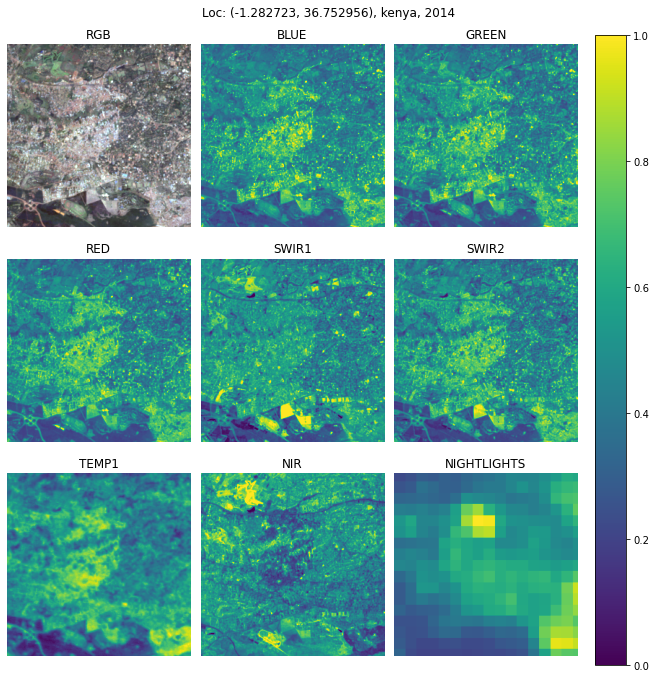

In [8]:
# 2014
tfrecord_path = TFRECORD_PATH_TEMPLATE.format(year=2014)
feature_map = get_feature_map(tfrecord_path)
    
print(f'TFRecord path: {tfrecord_path}')
print('########################################################################')
plot_single_img(feature_map)

TFRecord path: data/ke_dhs_tfrecords_raw/kenya_2015.tfrecord.gz
########################################################################
Loc: (-1.262753, 36.757370), kenya, 2015


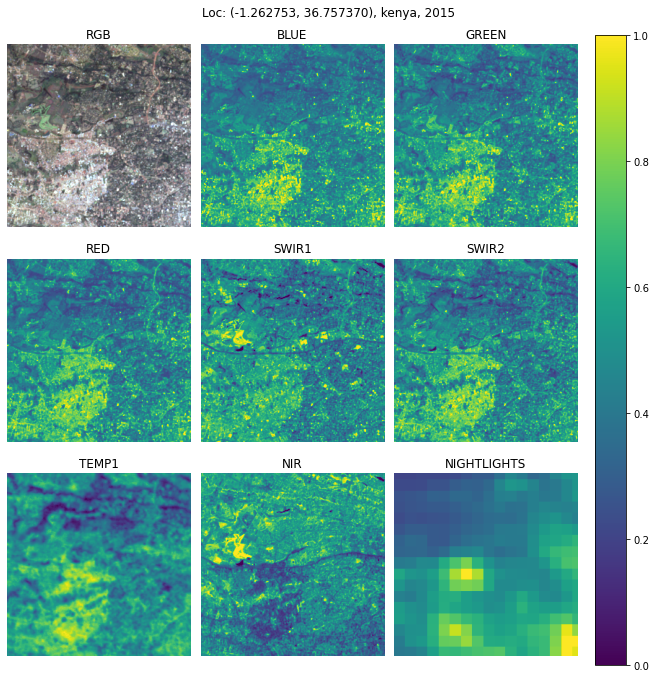

In [10]:
# 2015
tfrecord_path = TFRECORD_PATH_TEMPLATE.format(year=2015)
feature_map = get_feature_map(tfrecord_path)
    
print(f'TFRecord path: {tfrecord_path}')
print('########################################################################')
plot_single_img(feature_map)

In [11]:
# Getting statistics for each band 

def single_img_band_analysis(feature_map):
    '''perform basic band analysis'''
    nbands = len(BAND_ORDER)
    nrows = int(np.ceil(nbands / 2.0))
    fig, axs = plt.subplots(nrows, 2, figsize=[10, 10])

    img = np.stack([np.asarray(feature_map[band].float_list.value).reshape(255, 255) for band in BAND_ORDER], axis=2)

    print('Single Image Band Statistics')
    mins = np.min(img, axis=(0,1))
    maxs = np.max(img, axis=(0,1))
    means = np.mean(img, axis=(0,1))
    stds = np.std(img, axis=(0,1))
    nzs = np.sum(img == 0, axis=(0,1)) # number of zeros
    for i, band in enumerate(BAND_ORDER):
        print('{}\t- min: {:0.6g}\t max: {:0.6g}\t avg: {:0.6g}\t std: {:0.6g}\t nz: {}'.format(band, mins[i], maxs[i],
                                                                                                means[i], stds[i], nzs[i]))
        ax = axs[i % nrows, i // nrows]
        ax.hist(img[:,:,i].flatten(), bins=255)
        ax.set_title(band)
        ax.set_yscale('log')

    # number of pixels that are entirely zero
    nz_pixels = np.sum(np.all(img == 0, axis=2))
    print('Number of all-0 pixels:', nz_pixels)

    print('')
    print('Single Image Band Statistics - Ignoring 0 values')
    for i, band in enumerate(BAND_ORDER):
        b = img[:,:,i]
        bnz = b[b > 0]
        if len(bnz) == 0:
            print(f'Band {band} is all 0')
        else:
            print('{}\t- min: {:0.6g}\t max: {:0.6g}\t avg: {:0.6g}\t std: {:0.6g}'.format(band, np.min(bnz), np.max(bnz),
                                                                                           np.mean(bnz), np.std(bnz)))

    fig.tight_layout()
    plt.show()

########################################################################
Single Image Band Statistics
BLUE	- min: 0.0127	 max: 0.29845	 avg: 0.0484241	 std: 0.0146546	 nz: 0
GREEN	- min: 0.0309	 max: 0.38465	 avg: 0.0737382	 std: 0.0186995	 nz: 0
RED	- min: 0.0261	 max: 0.45695	 avg: 0.0830791	 std: 0.028538	 nz: 0
SWIR1	- min: 0.0198	 max: 0.47605	 avg: 0.199161	 std: 0.0390338	 nz: 0
SWIR2	- min: 0.0156	 max: 0.46435	 avg: 0.143066	 std: 0.0457108	 nz: 0
TEMP1	- min: 291.8	 max: 306.7	 avg: 298.867	 std: 2.46014	 nz: 0
NIR	- min: 0.0477	 max: 0.495	 avg: 0.239252	 std: 0.0408889	 nz: 0
NIGHTLIGHTS	- min: 1.86282	 max: 29.6071	 avg: 12.1756	 std: 5.82723	 nz: 0
Number of all-0 pixels: 0

Single Image Band Statistics - Ignoring 0 values
BLUE	- min: 0.0127	 max: 0.29845	 avg: 0.0484241	 std: 0.0146546
GREEN	- min: 0.0309	 max: 0.38465	 avg: 0.0737382	 std: 0.0186995
RED	- min: 0.0261	 max: 0.45695	 avg: 0.0830791	 std: 0.028538
SWIR1	- min: 0.0198	 max: 0.47605	 avg: 0.199161	 std: 0.03

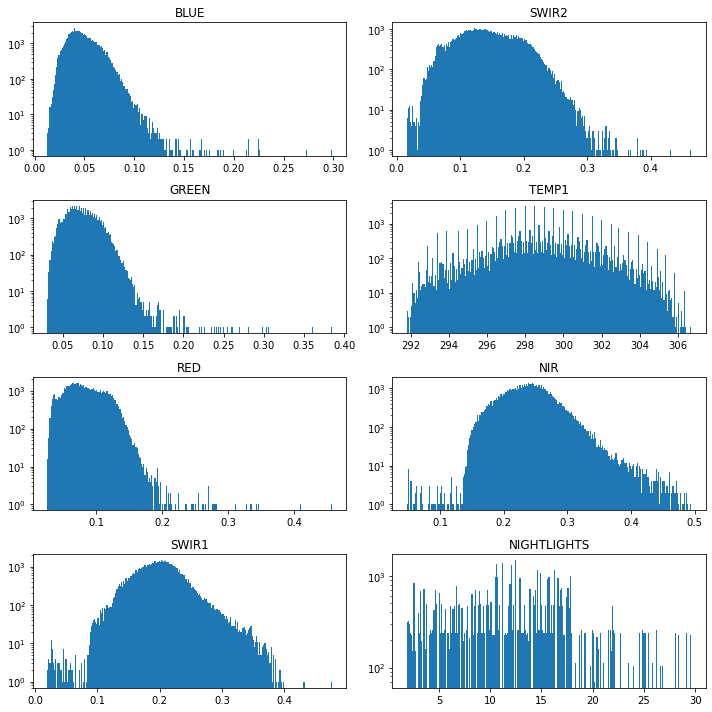

In [12]:
# 2014 
feature_map = get_feature_map(TFRECORD_PATH_TEMPLATE.format(year=2014))

print('########################################################################')
single_img_band_analysis(feature_map)

########################################################################
Single Image Band Statistics
BLUE	- min: 0.0145	 max: 0.214	 avg: 0.0446988	 std: 0.0148504	 nz: 0
GREEN	- min: 0.0305	 max: 0.2555	 avg: 0.0719845	 std: 0.0185818	 nz: 0
RED	- min: 0.0252	 max: 0.3174	 avg: 0.0810916	 std: 0.0282821	 nz: 0
SWIR1	- min: 0.0203	 max: 0.4259	 avg: 0.19528	 std: 0.0337349	 nz: 0
SWIR2	- min: 0.0154	 max: 0.38555	 avg: 0.139771	 std: 0.0434681	 nz: 0
TEMP1	- min: 293.4	 max: 305.8	 avg: 299.549	 std: 2.09607	 nz: 0
NIR	- min: 0.03515	 max: 0.49535	 avg: 0.24502	 std: 0.0405501	 nz: 0
NIGHTLIGHTS	- min: 2.01038	 max: 40.0704	 avg: 14.3952	 std: 6.99353	 nz: 0
Number of all-0 pixels: 0

Single Image Band Statistics - Ignoring 0 values
BLUE	- min: 0.0145	 max: 0.214	 avg: 0.0446988	 std: 0.0148504
GREEN	- min: 0.0305	 max: 0.2555	 avg: 0.0719845	 std: 0.0185818
RED	- min: 0.0252	 max: 0.3174	 avg: 0.0810916	 std: 0.0282821
SWIR1	- min: 0.0203	 max: 0.4259	 avg: 0.19528	 std: 0.0337349
SW

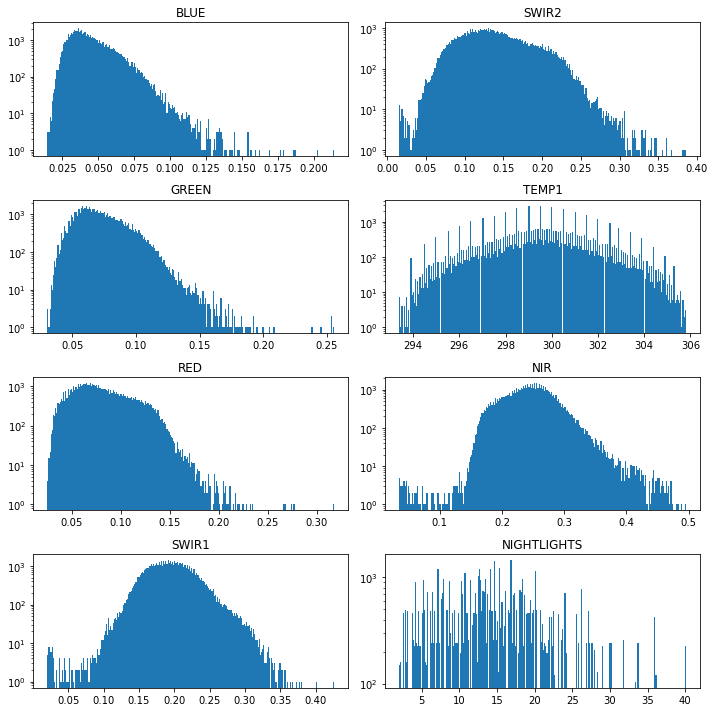

In [13]:
# 2015
feature_map = get_feature_map(TFRECORD_PATH_TEMPLATE.format(year=2015))

print('########################################################################')
single_img_band_analysis(feature_map)

# Band Analysis for ALL Images

In [16]:
tf.compat.v1.disable_eager_execution()

tfrecord_paths = [TFRECORD_PATH_TEMPLATE.format(year=2014), TFRECORD_PATH_TEMPLATE.format(year=2015)]
    
'''Calculates and prints the statistics of all images in our dataset'''
iter_init, batch_op = batcher.Batcher(tfrecord_files=tfrecord_paths, label_name=None, ls_bands='ms', nl_band='merge',
                                      batch_size=128, shuffle=False, augment=False, clipneg=False, normalize=None, 
                                      scalar_features=None).get_batch()


{'images': array([[[[3.32500003e-02, 4.82500009e-02, 5.02000004e-02, ...,
          2.95000000e+02, 2.49899998e-01, 4.78754044e+00],
         [3.29499990e-02, 4.80000004e-02, 5.03499992e-02, ...,
          2.94350006e+02, 2.45299995e-01, 3.19191313e+00],
         [2.74500009e-02, 3.95000018e-02, 3.55000012e-02, ...,
          2.93850006e+02, 2.25649998e-01, 3.19191313e+00],
         ...,
         [6.04999997e-02, 8.92999992e-02, 1.23599999e-01, ...,
          3.01500000e+02, 2.74800003e-01, 2.80308704e+01],
         [5.26500009e-02, 8.14500004e-02, 9.26000029e-02, ...,
          3.01399994e+02, 2.71100014e-01, 2.80308704e+01],
         [5.13000004e-02, 7.58500025e-02, 8.60499963e-02, ...,
          3.01500000e+02, 2.37499997e-01, 2.80308704e+01]],

        [[3.42000015e-02, 5.26000001e-02, 5.49000017e-02, ...,
          2.96000000e+02, 2.22000003e-01, 4.78754044e+00],
         [3.09999995e-02, 4.67999987e-02, 4.65999991e-02, ...,
          2.95500000e+02, 2.51300007e-01, 3.19191313e+00

In [18]:
def analyze_tfrecord_batch(iter_init, batch_op, total_num_images, nbands, k):
    '''Calculates per-band statistics.
    A good pixel is one where at least 1 band is > 0.
    Args
    - iter_init: tf.Op, operation to initialize iterator, or None if not needed
    - batch_op: dict, str -> tf.Tensor
        - 'images': tf.Tensor, type float32, shape [batch_size, 224, 224, nbands]
        - 'locs': tf.Tensor, type float32, shape [batch_size, 2], each row is [lat, lon]
        - 'years': tf.Tensor, type int32, shape [batch_size]
    - total_num_images: int
    - nbands: int
    Returns: dict
    - 'num_good_pixels': np.array, shape [total_num_images], type int, # of good pixels per image
    - 'mins': np.array, shape [nbands], type float64, min value per band
    - 'mins_nz': np.array, shape [nbands], type float64, min value per band excluding values <= 0
    - 'mins_goodpx': np.array, shape [nbands], type float64, min value per band among good pixels
    - 'maxs': np.array, shape [nbands], type float64, max value per band
    - 'sums': np.array, shape [nbands], type float64, sum of values per band, excluding values <= 0
    - 'sum_sqs': np.array, shape [nbands], type float64, sum of squared-values per band, excluding values <= 0
    - 'nz_pixels': np.array, shape [nbands], type int64, # of non-zero pixels per band
    '''
    images_count = 0

    # statistics for each band: min, max, sum, sum of squares, number of non-zero pixels
    mins = np.ones(nbands, dtype=np.float64) * np.inf
    mins_nz = np.ones(nbands, dtype=np.float64) * np.inf
    mins_goodpx = np.ones(nbands, dtype=np.float64) * np.inf
    maxs = np.zeros(nbands, dtype=np.float64)
    sums = np.zeros(nbands, dtype=np.float64)
    sum_sqs = np.zeros(nbands, dtype=np.float64)
    nz_pixels = np.zeros(nbands, dtype=np.int64)

    batch_times = []
    processing_times = []
    start = time.time()

    # number of `good pixels` in each image
    num_good_pixels: list[int] = []

    with tf.compat.v1.Session() as sess:
        if iter_init is not None:
            sess.run(iter_init)

        while True:
            try:
                batch_start_time = time.time()
                batch_np = sess.run(batch_op)
                img_batch, year_batch = batch_np['images'], batch_np['years']
                batch_size = len(img_batch)

                processing_start_time = time.time()
                batch_times.append(processing_start_time - batch_start_time)

                dmsp_mask = (year_batch < 2012)
                dmsp_bands = np.arange(nbands-1)
                viirs_mask = ~ dmsp_mask
                viirs_bands = [i for i in range(nbands) if i != nbands-2]

                batch_goodpx = np.any(img_batch > 0, axis=3)
                num_good_pixels_per_image = np.sum(batch_goodpx, axis=(1,2))
                num_good_pixels.extend(num_good_pixels_per_image)

                img_batch_positive = np.where(img_batch <= 0, np.inf, img_batch)
                img_batch_nonneg = np.where(img_batch < 0, 0, img_batch)

                for mask, bands in [(dmsp_mask, dmsp_bands), (viirs_mask, viirs_bands)]:
                    if np.sum(mask) == 0: continue

                    imgs = img_batch[mask]
                    imgs_positive = img_batch_positive[mask]
                    imgs_nonneg = img_batch_nonneg[mask]

                    goodpx = batch_goodpx[mask]
                    imgs_goodpx = imgs[goodpx]  # shape [len(mask), nbands]

                    mins[bands] = np.minimum(mins[bands], np.min(imgs, axis=(0,1,2)))
                    mins_nz[bands] = np.minimum(mins_nz[bands], np.min(imgs_positive, axis=(0,1,2)))
                    mins_goodpx[bands] = np.minimum(mins_goodpx[bands], np.min(imgs_goodpx, axis=0))
                    maxs[bands] = np.maximum(maxs[bands], np.max(imgs, axis=(0,1,2)))

                    # use np.float64 to avoid significant loss of precision in np.sum
                    sums[bands] += np.sum(imgs_nonneg, axis=(0,1,2), dtype=np.float64)
                    sum_sqs[bands] += np.sum(imgs_nonneg ** 2, axis=(0,1,2), dtype=np.float64)
                    nz_pixels[bands] += np.sum(imgs > 0, axis=(0,1,2))

                processing_times.append(time.time() - processing_start_time)

                images_count += batch_size
                if images_count % 1024 == 0:
                    print(f'\rProcessed {images_count}/{total_num_images} images...', end='')
            except tf.errors.OutOfRangeError:
                break

    total_time = time.time() - start
    #assert len(num_good_pixels) == images_count
    #assert images_count == total_num_images

    print(f'\rFinished. Processed {images_count} images.')
    print('Time per batch - mean: {:0.3f}s, std: {:0.3f}s'.format(
        np.mean(batch_times), np.std(batch_times)))
    print('Time to process each batch - mean: {:0.3f}s, std: {:0.3f}s'.format(
        np.mean(processing_times), np.std(processing_times)))
    print('Total time: {:0.3f}s, Num batches: {}'.format(total_time, len(batch_times)))

    stats = {'num_good_pixels': np.array(num_good_pixels), 'mins': mins, 'mins_nz': mins_nz, 'mins_goodpx': mins_goodpx,
             'maxs': maxs, 'sums': sums, 'sum_sqs': sum_sqs, 'nz_pixels': nz_pixels}
    
    return stats

In [20]:
stats = analyze_tfrecord_batch(iter_init, batch_op, total_num_images=len(tfrecord_paths), nbands=len(BANDS_ORDER), k=10)

Finished. Processed 1830 images.
Time per batch - mean: 0.181s, std: 0.569s
Time to process each batch - mean: 3.216s, std: 0.709s
Total time: 51.057s, Num batches: 15


In [21]:
def print_analysis_results(stats, band_order):
    '''Prints per-band statistics based on different pixel criteria.
    Args
    - stats: dict, see the output of analyze_tfrecord_batch() above.
    - band_order: list of str, names of bands
    '''
    num_good_pixels, mins, mins_nz, mins_goodpx, maxs, sums, sum_sqs, nz_pixels = [stats[k] for k in
        ['num_good_pixels', 'mins', 'mins_nz', 'mins_goodpx', 'maxs', 'sums', 'sum_sqs', 'nz_pixels'] ]
    
    images_count = len(num_good_pixels)
    total_pixels_per_band = images_count * (224 ** 2)  # per band

    print('Statistics including bad pixels')
    means = sums / float(total_pixels_per_band)
    stds = np.sqrt(sum_sqs/float(total_pixels_per_band) - means**2)
    for i, band_name in enumerate(band_order):
        print('Band {:8s} - mean: {:10.6f}, std: {:>9.6f}, min: {:>11.6g}, max: {:11.6f}'.format(band_name, means[i], 
                                                                                                 stds[i], mins[i], maxs[i]))

    print('')
    
    print('Statistics ignoring any 0s and negative values')
    means = sums / nz_pixels
    stds = np.sqrt(sum_sqs/nz_pixels - means**2)
    avg_nz_pixels = nz_pixels.astype(np.float32) / images_count
    for i, band_name in enumerate(band_order):
        print('Band {:8s} - mean: {:10.6f}, std: {:>9.6f}, min: {:>11.6g}, max: {:11.6f}, mean_nz: {:0.6f}'.format(
                                                       band_name, means[i], stds[i], mins_nz[i], maxs[i], avg_nz_pixels[i]))

    print('')
    
    print('Statistics excluding the bad pixels')
    num_total_pixels = np.sum(num_good_pixels)
    means = sums / float(num_total_pixels)
    stds = np.sqrt(sum_sqs/float(num_total_pixels) - means**2)
    for i, band_name in enumerate(band_order):
        print('Band {:8s} - mean: {:10.6f}, std: {:>9.6f}, min: {:>11.6g}, max: {:11.6f}'.format(band_name, means[i], 
                                                                                          stds[i], mins_goodpx[i], maxs[i]))

        
print_analysis_results(stats, BANDS_ORDER)

Statistics including bad pixels
Band BLUE     - mean:   0.047784, std:  0.021073, min:  0.00416667, max:    0.495950
Band GREEN    - mean:   0.078575, std:  0.028186, min:      0.0124, max:    0.657100
Band RED      - mean:   0.089048, std:  0.047697, min:       0.009, max:    0.707800
Band SWIR1    - mean:   0.229678, std:  0.077633, min:      0.0072, max:    1.300800
Band SWIR2    - mean:   0.150437, std:  0.072214, min:     0.00535, max:    1.369500
Band TEMP1    - mean: 298.878257, std:  3.530056, min:       284.7, max:  313.649994
Band NIR      - mean:   0.270299, std:  0.055032, min:      0.0131, max:    0.778200
Band DMSP     - mean:   0.000000, std:  0.000000, min:         inf, max:    0.000000
Band VIIRS    - mean:   1.162537, std:  4.314718, min:  -0.0881637, max:  128.130386

Statistics ignoring any 0s and negative values
Band BLUE     - mean:   0.047784, std:  0.021073, min:  0.00416667, max:    0.495950, mean_nz: 50176.000000
Band GREEN    - mean:   0.078575, std:  0.02818

<ipython-input-21-6c99a6f90222>:23: RuntimeWarning: invalid value encountered in true_divide
  means = sums / nz_pixels
<ipython-input-21-6c99a6f90222>:24: RuntimeWarning: invalid value encountered in true_divide
  stds = np.sqrt(sum_sqs/nz_pixels - means**2)


In [22]:
num_good_pixels = stats['num_good_pixels']
images_count = len(num_good_pixels)
print('num total pixels:', images_count * (224**2))
print('num total good pixels:', np.sum(num_good_pixels))
print('mean number of non-0 pixels in each band:', np.mean(stats['nz_pixels']))

num total pixels: 91822080
num total good pixels: 91822080
mean number of non-0 pixels in each band: 80907529.1111111


# Plotting Wealthpool Distribution for surveys from each year(2014, 2015)

NOTE: I use wealthpoll as the label for this analysis and it therefore makes sense to visualise it's distribution.

In [23]:
def setup_ax(fig, pos=(1, 1, 1)):
    '''
    Args
    - fig: matplotlib.figure.Figure
    - pos: 3-tuple of int, axes position (nrows, ncols, index)

    Returns: matplotlib.axes.Axes
    '''
    ax = fig.add_subplot(*pos, projection=ccrs.PlateCarree())

    # draw land (better version of cfeature.LAND)
    land = cfeature.NaturalEarthFeature(category='physical', name='land', scale='10m', edgecolor='face', 
                                        facecolor=cfeature.COLORS['land'], zorder=-1)
    ax.add_feature(cfeature.LAND)

    # draw borders of countries (better version of cfeature.BORDERS)
    countries = cfeature.NaturalEarthFeature(category='cultural', name='admin_0_boundary_lines_land', scale='10m',
                                             edgecolor='black', facecolor='none')
    ax.add_feature(countries)

    # draw coastline (better version of cfeature.COASTLINE)
    coastline = cfeature.NaturalEarthFeature(category='physical', name='coastline', scale='10m', edgecolor='black', 
                                             facecolor='none')
    ax.add_feature(coastline)

    # draw lakes (better version of cfeature.LAKES)
    lakes = cfeature.NaturalEarthFeature(category='physical', name='lakes', scale='10m', edgecolor='face', 
                                         facecolor=cfeature.COLORS['water'])
    ax.add_feature(lakes)

    # draw ocean (better version of cfeature.OCEAN)
    ocean = cfeature.NaturalEarthFeature(category='physical', name='ocean', scale='50m', edgecolor='face', 
                                         facecolor=cfeature.COLORS['water'], zorder=-1)
    ax.add_feature(ocean)

    # draw rivers (better version of cfeature.RIVERS)
    rivers = cfeature.NaturalEarthFeature(category='physical', name='rivers_lake_centerlines', scale='10m',
                                          edgecolor=cfeature.COLORS['water'], facecolor='none')
    ax.add_feature(rivers)

    # draw borders of states/provinces internal to a country
    states_provinces = cfeature.NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lines', scale='50m',
                                                    edgecolor='gray', facecolor='none')
    ax.add_feature(states_provinces)

    ax.set_aspect('equal')
    gridliner = ax.gridlines(draw_labels=True)
    gridliner.xlabels_top = False
    gridliner.ylabels_right = False
    
    return ax

In [30]:
def plot_country(country_year, survey_df):
    '''
    Args
    - country_year: str, e.g. 'angola_2011'
    - survey_df: pd.DataFrame, survey CSV for the given country_year
    '''
    columns = ['wealthpooled', 'lat', 'lon']
    data = pd.read_csv(survey_df)
    # data = data.loc[columns].astype(np.float32)


    fig = plt.figure(figsize=(15, 10))
    ax = setup_ax(fig)


    sc = ax.scatter(data['lon'], data['lat'], c=data['wealthpooled'], vmin=-1.3, vmax=2.7)
    fig.colorbar(sc, orientation='vertical')


    ax.set_title(country_year)
    ax.legend()
    plt.show()

C:\Users\HP\anaconda3\envs\planet_project\lib\site-packages\cartopy\mpl\gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
C:\Users\HP\anaconda3\envs\planet_project\lib\site-packages\cartopy\mpl\gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
No handles with labels found to put in legend.


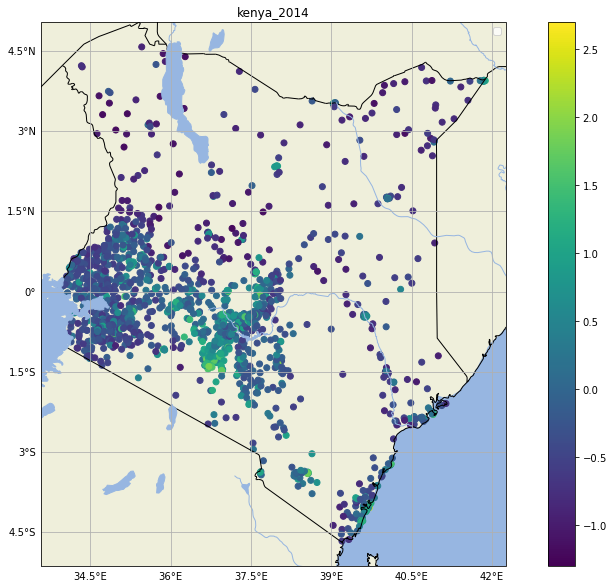

In [31]:
plot_country(country_year='kenya_2014', survey_df='data/ke_dhs_surveys/kenya_2014.csv')

No handles with labels found to put in legend.


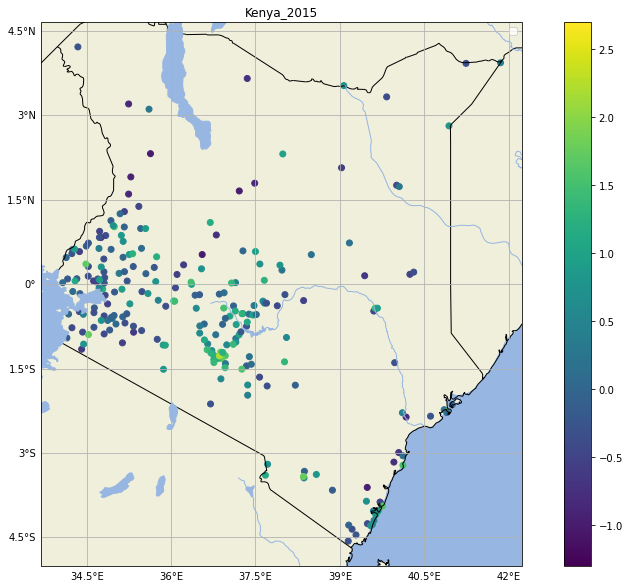

In [33]:
plot_country(country_year='Kenya_2015', survey_df='data/ke_dhs_surveys/kenya_2015.csv')

# Plotting Fold / Clusters

In [40]:
FOLDS = ['A', 'B', 'C', 'D', 'E']
MIN_DIST = 0.092841  

In [42]:
def plot_locs(locs, fig=None, pos=(1, 1, 1), figsize=(120, 20), title=None, colors=None, cbar_label=None, show_cbar=True,
              **scatter_kws: Any):
    '''
    Args
    - locs: np.array, shape [N, 2], each row is [lat, lon]
    - fig: matplotlib.figure.Figure
    - pos: 3-tuple of int, axes position (nrows, ncols, index)
    - figsize: list, [width, height] in inches, only used if fig is None
    - title: str, title of axes
    - colors: list of int, length N
    - cbar_label: str, label for the colorbar
    - show_cbar: bool, whether to show the colorbar
    - scatter_kws: other arguments for ax.scatter
    Returns: matplotlib.axes.Axes
    '''
    if fig is None:
        fig = plt.figure(figsize=figsize)
    ax = setup_ax(fig, pos)
    if title is not None:
        ax.set_title(title)

    if 's' not in scatter_kws:
        scatter_kws['s'] = 2
    pc = ax.scatter(locs[:, 1], locs[:, 0], c=colors, **scatter_kws)
    if colors is not None and show_cbar:
        cbar = fig.colorbar(pc, ax=ax, fraction=0.03)
        if cbar_label is not None:
            cbar.set_label(cbar_label)
    return ax


In [43]:
def create_folds(locs, min_dist, fold_names, verbose=True, plot_largest_clusters=0):
    '''Partitions locs into folds.
    Args
    - locs: np.array, shape [N, 2]
    - min_dist: float, minimum distance between folds
    - fold_names: list of str, names of folds
    - verbose: bool
    - plot_largest_clusters: int, number of largest clusters to plot
    Returns
    - folds: dict, fold name => sorted np.array of indices of locs belonging to that fold
    '''
    # there may be duplicate locs => we want to cluster based on unique locs
    unique_locs = np.unique(locs, axis=0)  # get unique rows

    # dict that maps each (lat, lon) tuple to a list of corresponding indices in the locs array
    locs_to_indices = defaultdict(list)
    for i, loc in enumerate(locs):
        locs_to_indices[tuple(loc)].append(i)

    # any point within `min_dist` of another point belongs to the same cluster
    # - cluster_labels assigns a cluster index (0-indexed) to each loc
    # - a cluster label of -1 means that the point is an outlier
    _, cluster_labels = sklearn.cluster.dbscan(X=unique_locs, eps=min_dist, min_samples=2, metric='euclidean')

    # mapping: cluster number => list of indices of points in that cluster
    # - if cluster label is -1 (outlier), then treat that unique loc as its own cluster
    neg_counter = -1
    clusters_dict = defaultdict(list)
    for loc, c in zip(unique_locs, cluster_labels):
        indices = locs_to_indices[tuple(loc)]
        if c < 0:
            c = neg_counter
            neg_counter -= 1
        clusters_dict[c].extend(indices)

    # sort clusters by descending cluster size
    sorted_clusters = sorted(clusters_dict.keys(), key=lambda c: -len(clusters_dict[c]))

    # greedily assign clusters to folds
    folds = {f: [] for f in fold_names}
    for c in sorted_clusters:
        # assign points in cluster c to smallest fold
        f = min(folds, key=lambda f: len(folds[f]))
        folds[f].extend(clusters_dict[c])

    for f in folds:
        folds[f] = np.sort(folds[f])

    # plot the largest clusters
    for i in range(plot_largest_clusters):
        c = sorted_clusters[i]
        indices = clusters_dict[c]
        title = 'cluster {c}: {n} points'.format(c=c, n=len(indices))
        plot_locs(locs[indices], figsize=(4, 4), title=title)

    if verbose:
        _, unique_counts = np.unique(cluster_labels, return_counts=True)

        num_outliers = np.sum(cluster_labels == -1)
        outlier_offset = int(num_outliers > 0)
        max_cluster_size = np.max(unique_counts[outlier_offset:])  # exclude outliers

        print('num clusters:', np.max(cluster_labels) + 1)  # clusters are 0-indexed
        print('num outliers:', num_outliers)
        print('max cluster size (excl. outliers):', max_cluster_size)

        fig, ax = plt.subplots(1, 1, figsize=(5, 5), constrained_layout=True)
        ax.hist(unique_counts[outlier_offset:], bins=50)  # exclude outliers
        ax.set(xlabel='cluster size', ylabel='count')
        ax.set_yscale('log')
        ax.set_title('histogram of cluster sizes (excluding outliers)')
        ax.grid(True)
        plt.show()

    return folds

In [38]:
dhs_df = pd.read_csv('data/ke_dhs_clusters.csv', float_precision='high', index_col=False)
dhs_locs = dhs_df[['lat', 'lon']].values
# print_loc_stats(dhs_locs)

C:\Users\HP\anaconda3\envs\planet_project\lib\site-packages\cartopy\mpl\gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
C:\Users\HP\anaconda3\envs\planet_project\lib\site-packages\cartopy\mpl\gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


num clusters: 125
num outliers: 262
max cluster size (excl. outliers): 389


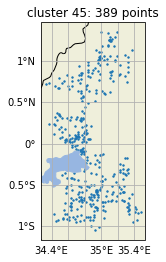

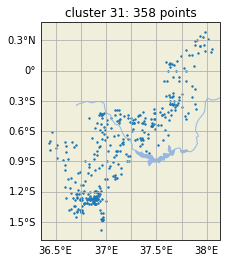

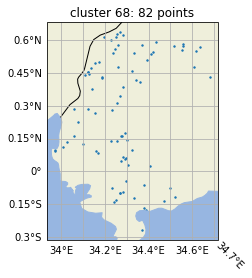

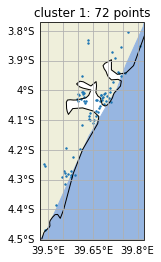

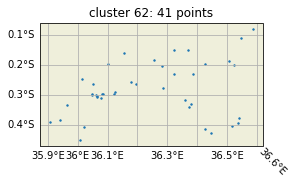

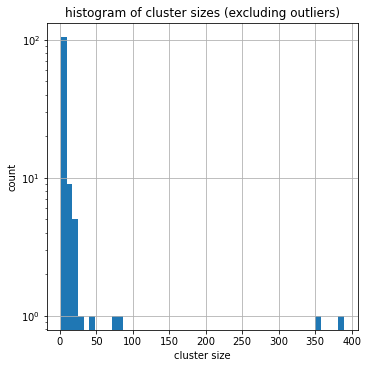

{'A': array([ 798,  799,  800,  801,  817,  818,  819,  820,  821,  822,  823,
         824,  825,  826,  827,  828,  829,  830,  831,  832,  834,  838,
         839,  840,  842,  844,  845,  846,  847,  848,  849,  850,  851,
         864,  865,  866,  867,  868,  869,  871,  872,  874,  875,  876,
         877,  878,  891,  892,  893,  909,  910,  911,  912,  913,  914,
         915,  916,  917,  918,  919,  920,  921,  922,  923,  924,  925,
         926,  927,  928,  929,  930,  931,  932,  933,  934,  935,  936,
         937,  938,  939,  940,  941,  942,  943,  944,  945,  946,  947,
         948,  949,  950,  951,  952,  953,  954,  955,  956,  957,  958,
         959,  960,  961,  962,  963,  964,  965,  966,  967,  968,  969,
         970,  971,  972,  973,  974,  975,  976,  977,  978,  979,  980,
         981,  982,  983,  984,  985,  986,  987,  988,  989, 1021, 1022,
        1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1032, 1036, 1082,
        1083, 1084, 1085, 1086, 1

In [44]:
create_folds(locs=dhs_locs, min_dist=MIN_DIST, fold_names=FOLDS, plot_largest_clusters=5)